In [1]:
# load needed modules
import numba 
import numpy as np

import time

import numpy as np
from numba import cuda
from math import ceil 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#print out gpu information

gpu = numba.cuda.get_current_device()
print("name = %s" % gpu.name)
print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))
print("maxBlockDimX = %s" % str(gpu.MAX_BLOCK_DIM_X))
print("maxBlockDimY = %s" % str(gpu.MAX_BLOCK_DIM_Y))
print("maxBlockDimZ = %s" % str(gpu.MAX_BLOCK_DIM_Z))
print("maxGridDimX = %s" % str(gpu.MAX_GRID_DIM_X))
print("maxGridDimY = %s" % str(gpu.MAX_GRID_DIM_Y))
print("maxGridDimZ = %s" % str(gpu.MAX_GRID_DIM_Z))
print("maxSharedMemoryPerBlock = %s" % str(gpu.MAX_SHARED_MEMORY_PER_BLOCK))
print("asyncEngineCount = %s" % str(gpu.ASYNC_ENGINE_COUNT))
print("canMapHostMemory = %s" % str(gpu.CAN_MAP_HOST_MEMORY))
print("multiProcessorCount = %s" % str(gpu.MULTIPROCESSOR_COUNT))
print("warpSize = %s" % str(gpu.WARP_SIZE))
print("unifiedAddressing = %s" % str(gpu.UNIFIED_ADDRESSING))
print("pciBusID = %s" % str(gpu.PCI_BUS_ID))
print("pciDeviceID = %s" % str(gpu.PCI_DEVICE_ID))

name = b'Tesla K80'
maxThreadsPerBlock = 1024
maxBlockDimX = 1024
maxBlockDimY = 1024
maxBlockDimZ = 64
maxGridDimX = 2147483647
maxGridDimY = 65535
maxGridDimZ = 65535
maxSharedMemoryPerBlock = 49152
asyncEngineCount = 2
canMapHostMemory = 1
multiProcessorCount = 13
warpSize = 32
unifiedAddressing = 1
pciBusID = 132
pciDeviceID = 0


In [3]:
#generate dummy data for test

Nz, Ny, Nx = 128, 512, 128

real_data = (np.ones((Nz, Ny, Nx)) * np.sin(np.linspace(0, 20, Ny)[np.newaxis, :, np.newaxis])*0.5 
             + np.random.normal(scale=1.0, size=(Nz, Ny, Nx)) )

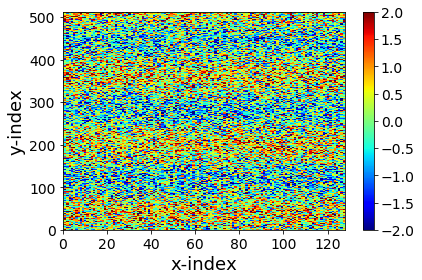

In [4]:
#visulize date: before filtering:

plt.pcolormesh(real_data[Nz//2,:, :], vmin=-2, vmax=2, cmap=plt.cm.jet)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.xlabel("x-index", fontsize=18)
plt.xticks( fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks( fontsize=14)

plt.tight_layout()

plt.show()

In [5]:
# define the output result: same size of input data
output_data_ = real_data.copy()

#define the stencil size (3D)
stencil = (2, 1, 2)

In [20]:
# ================================= median ================================== #

'''
 @param:
     - input_data:  np.array, 3D data to filter
     - output_data: np.array, 3D data after filtering,same size of input (because cuda kernel function can't return value)
     - fkt:         function, numba_median, numba_avgerage, ... (what else?) ==> Gaussian?
     - stencil:     tuple of size 3, the dimension of 3D stencil 
     
 @function: 
     stencil filter on GPU, reference: https://en.wikipedia.org/wiki/Stencil_code
'''

# tile size?


@cuda.jit
def gpu_smooth_kernel_naive(input_data, output_data, stencil_z, stencil_y, stencil_x, Nz, Ny, Nx):
    
    
    # ==== stencil size ==== #
    #dx = stencil_[0] dosen't work, compile issue
    #dy = stencil_[1]
    #dz = stencil_[2]
    dx = stencil_x * 2 + 1
    dy = stencil_y * 2 + 1
    dz = stencil_z * 2 + 1
    # ====================== #
 
    # ==== global thread index ==== #
    
    row_init = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    col_init = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    depth_init = cuda.threadIdx.z + cuda.blockIdx.z * cuda.blockDim.z

    # ============================= # 
    
    # ==== shared mem. ==== #   
    times = 1 # now every thread only loads at most 2 times to mem.
    tile_size_z = dz * times #1 * 5 = 5
    tile_size_y = dy * times #1 * 3 = 3
    tile_size_x = dx * times #1 * 5 = 5

    '''
    times = 4 # now every thread only loads at most 2 times to mem.
    tile_size_z = dz # 9
    tile_size_y = dy # 7
    tile_size_x = dx * times # 9
    '''
    
    shared_mem_size_z = tile_size_z + stencil_z * 2 #  stencil_z * 2: including apron  9
    shared_mem_size_y = tile_size_y + stencil_y * 2 #  5
    shared_mem_size_x = tile_size_x + stencil_x * 2 #  9

    #shared_mem = cuda.shared.array(shape=(shared_mem_size_z, shared_mem_size_y, shared_mem_size_x), dtype=float32)
    # compile issue: https://stackoverflow.com/questions/30510580/numba-cuda-shared-memory-size-at-runtime 
    shared_mem = cuda.shared.array(shape=(9, 5, 9), dtype=numba.float32)

    # grid stride:
    for depth_global in range(depth_init, Nz, cuda.blockDim.z * cuda.gridDim.z):
        z_min = max(depth_global - stencil_z, 0)
        z_max = min(depth_global + stencil_z + 1, Nz)
        for col_global in range(col_init, Ny, cuda.blockDim.y * cuda.gridDim.y):
            y_min = max(col_global - stencil_y, 0)
            y_max = min(col_global + stencil_y + 1, Ny)
            for row_global in range(row_init, Nx, cuda.blockDim.x * cuda.gridDim.x):
                x_min = max(row_global - stencil_x, 0)
                x_max = min(row_global + stencil_x + 1, Nx)
                
                # split the block into tiles
                # Preload data into shared memory
                # PS. different bounding method also influences. ===========> modify it when use other bounding method case   
                            
                # split the tiles into filters: 1 tile has times(10) filters
                # 2-steps load data:
                # https://www.evl.uic.edu/sjames/cs525/final.html
                # 1. 
                dest = cuda.threadIdx.x + (cuda.threadIdx.y * tile_size_x) + (cuda.threadIdx.z * tile_size_y * tile_size_x)
                destTmp = dest
                destX = destTmp % shared_mem_size_x
                destTmp = int(destTmp / shared_mem_size_x)
                destY = destTmp % shared_mem_size_y
                destTmp = int(destTmp / shared_mem_size_y);
                destZ = destTmp
                # for example: tile_size_x = 12, tile_size_y = 14, tile_size_x = 16
                # dest = x + 12 * y + 12 * 14 * z
                # how to get x, y, z? ==> mod and /
                
                srcZ = destZ - stencil_z + depth_global - cuda.threadIdx.z
                srcY = destY - stencil_y + col_global - cuda.threadIdx.y
                srcX = destX - stencil_x + row_global - cuda.threadIdx.x
                
                if(srcZ >= 0 and srcZ < Nz and srcY >= 0 and srcY < Ny and srcX >= 0 and srcX < Nx):
                    shared_mem[destZ, destY, destX] = input_data[srcZ, srcY, srcX]
                else:
                    shared_mem[destZ, destY, destX] = 0.0
                
                # 2.
                for iter in (1, int((shared_mem_size_z * shared_mem_size_y *shared_mem_size_x) / (tile_size_x*tile_size_y*tile_size_z)) + 1):
                    dest = cuda.threadIdx.x + (cuda.threadIdx.y * tile_size_x) + (cuda.threadIdx.z * tile_size_y * tile_size_x) + iter * tile_size_x * tile_size_y * tile_size_z

                    destTmp = dest
                    destX = destTmp % shared_mem_size_x
                    destTmp = int(destTmp / shared_mem_size_x)
                    destY = destTmp % shared_mem_size_y
                    destTmp = int(destTmp / shared_mem_size_y);
                    destZ = destTmp
                    
                    #srcZ = (cuda.blockIdx.z * tile_size_z) + destZ - stencil_z
                    #srcY = (cuda.blockIdx.y * tile_size_y) + destY - stencil_y
                    #srcX = (cuda.blockIdx.x * tile_size_x) + destX - stencil_x
                    
                    srcZ = destZ - stencil_z + depth_global - cuda.threadIdx.z
                    srcY = destY - stencil_y + col_global - cuda.threadIdx.y
                    srcX = destX - stencil_x + row_global - cuda.threadIdx.x
                    if((destX < shared_mem_size_x) and (destY < shared_mem_size_y) and (destZ < shared_mem_size_z)):
                        if(srcZ >= 0 and srcZ < Nz and srcY >= 0 and srcY < Ny and srcX >= 0 and srcX < Nx):
                            shared_mem[destZ, destY, destX] = input_data[srcZ, srcY, srcX]
                        else:
                            shared_mem[destZ, destY, destX] = 0.0                              
                cuda.syncthreads()
                
                # now let's try to calculate mean value
                sum = 0.0
                for z in range(dz):
                    for y in range(dy):
                        for x in range(dx):
                            sum += shared_mem[cuda.threadIdx.z + z, cuda.threadIdx.y + y, cuda.threadIdx.x + x]
                # here ignore bounding pixel
                
                output_data[depth_global, col_global, row_global] = sum / ((z_max - z_min) * (y_max - y_min) * (x_max - x_min))
                cuda.syncthreads()
        

 
 
        
def lauch_kernel(input_data, output_data, stencil_):
    # TODO: set blocksize, gridsize and lauch kernel
    # define threads and blocks
    # threads = 128
    # blocks = 2048/threads * 13 
    # if we want to use shared mem.
    # then the tile_size must be == block_size
    threads_z = (stencil_[0] * 2 + 1) * 1
    threads_y = (stencil_[1] * 2 + 1) * 1
    threads_x = (stencil_[2] * 2 + 1) * 1
    blocks = (8, 8, 8)
    # TODO: tune this parameter
    
    print("==================")
    print("threads_z: " + str(threads_z))
    print("threads_y: " + str(threads_y))
    print("threads_x: " + str(threads_x))
    
    print("blocks: " + str(blocks))
    print("==================")
    #print(output_data)
    Nz, Ny, Nx = np.shape(input_data) # why here z, y, x ?
    stencil_z, stencil_y, stencil_x = stencil_[0], stencil_[1], stencil_[2]
    start = time.time()
    # call CUDA kernel
    gpu_smooth_kernel_naive[blocks, (threads_x, threads_y, threads_z)](input_data, output_data,stencil_z, stencil_y, stencil_x, Nz, Ny, Nx)
    #print(output_data)
    
    end = time.time()
    print("Elapsed (gpu naive with compilation) = %s" % (end - start))

    start = time.time()
    gpu_smooth_kernel_naive[blocks, (threads_x, threads_y, threads_z)](input_data, output_data,stencil_z, stencil_y, stencil_x, Nz, Ny, Nx)
    end = time.time()
    print("Elapsed (gpu naive without compilation) = %s" % (end - start))


In [21]:
stencil_t = (2, 1, 2)
lauch_kernel(real_data, output_data_, stencil_t)


threads_z: 5
threads_y: 3
threads_x: 5
blocks: (8, 8, 8)
Elapsed (gpu naive with compilation) = 1.4182722568511963
Elapsed (gpu naive without compilation) = 0.08557748794555664


[[[ 0.06029839  0.06373804 -0.01752193 ...  0.09376243  0.11079251
    0.16050792]
  [ 0.08741926  0.07222539  0.02107386 ... -0.00974433  0.03116932
    0.09990387]
  [-0.03528126 -0.00967013 -0.0280414  ... -0.03255    -0.02561145
    0.04571648]
  ...
  [ 0.13307504  0.0985891   0.08626854 ...  0.13126808  0.17892643
    0.24001519]
  [ 0.06399358  0.09007286  0.16143316 ...  0.15190428  0.10686917
    0.11943482]
  [ 0.16874518  0.19563929  0.22221161 ... -0.04471078 -0.13939733
   -0.08533002]]

 [[ 0.04522379  0.04780353 -0.01314145 ...  0.07032183  0.08309438
    0.12038094]
  [ 0.06556444  0.05416904  0.01580539 ... -0.00730825  0.02337699
    0.0749279 ]
  [-0.02646095 -0.0072526  -0.02103105 ... -0.0244125  -0.01920859
    0.03428736]
  ...
  [ 0.09980628  0.07394182  0.06470141 ...  0.09845106  0.13419482
    0.18001139]
  [ 0.04799519  0.06755464  0.12107487 ...  0.11392821  0.08015188
    0.08957612]
  [ 0.12655888  0.14672947  0.1666587  ... -0.03353308 -0.104548
   -0.06

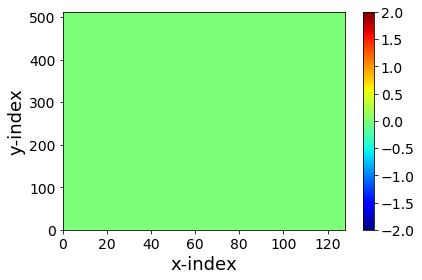

In [22]:
#visulize date: after filtering:
print(output_data_)
plt.pcolormesh(output_data_[Nz//2,:, :], vmin=-2, vmax=2, cmap=plt.cm.jet)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.xlabel("x-index", fontsize=18)
plt.xticks( fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks( fontsize=14)

plt.tight_layout()

plt.show()